In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Add, SpectralNormalization
from tensorflow.keras import layers
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import Image

In [3]:
class ResidualDenseBlock(tf.keras.Model):
  def __init__(self, **kwargs):
    super(ResidualDenseBlock, self).__init__(**kwargs)
    self.conv_1 = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="SAME")
    self.conv_2 = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="SAME")
    self.conv_3 = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="SAME")
    self.conv_4 = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="SAME")
    self.conv_5 = layers.Conv2D(64, (3, 3), strides=(1, 1), padding="SAME")

    self.activation_1 = tf.keras.layers.LeakyReLU(alpha=0.2)
    self.activation_2 = tf.keras.layers.LeakyReLU(alpha=0.2)
    self.activation_3 = tf.keras.layers.LeakyReLU(alpha=0.2)
    self.activation_4 = tf.keras.layers.LeakyReLU(alpha=0.2)

  def call(self, x):
    x1 = self.activation_1(self.conv_1(x))
    x2 = self.activation_2(self.conv_2(layers.concatenate([x, x1])))
    x3 = self.activation_3(self.conv_3(layers.concatenate([x, x1, x2])))
    x4 = self.activation_4(self.conv_4(layers.concatenate([x, x1, x2, x3])))
    x5 = self.conv_5(layers.concatenate([x, x1, x2, x3, x4]))

    # Emperically, we use 0.2 to scale the residual for better performance
    return x5 * 0.2 + x

class RRDB(tf.keras.Model):
  def __init__(self, **kwargs):
    super(RRDB, self).__init__(**kwargs)
    self.res_1 = ResidualDenseBlock()
    self.res_2 = ResidualDenseBlock()
    self.res_3 = ResidualDenseBlock()

  def call(self, x_input):
    x = self.res_1(x_input)
    x = self.res_2(x)
    x = self.res_3(x)

    return x * 0.2 + x_input

In [4]:
class RRDBNet(tf.keras.Model):
  def __init__(self, **kwargs):
    super(RRDBNet, self).__init__(**kwargs)
    self.first_conv = layers.Conv2D(64, 3, strides=(1, 1), padding="SAME") # padding 1
    self.rb_1 = RRDB()
    self.rb_2 = RRDB()
    self.rb_3 = RRDB()
    self.rb_4 = RRDB()
    self.rb_5 = RRDB()
    self.rb_6 = RRDB()
    self.conv_body = layers.Conv2D(64, 3, strides=(1, 1), padding="SAME") # padding 1

    self.up_1 = layers.UpSampling2D()
    self.conv_1 = layers.Conv2D(64, 3, strides=(1, 1), padding="SAME") # padding 1
    self.activation_1 = tf.keras.layers.LeakyReLU(alpha=0.2)

    self.up_2 = layers.UpSampling2D()
    self.conv_2 = layers.Conv2D(64, 3, strides=(1, 1), padding="SAME") # padding 1
    self.activation_2 = tf.keras.layers.LeakyReLU(alpha=0.2)

    self.conv_3 = layers.Conv2D(64, 3, strides=(1, 1), padding="SAME") # padding 1
    self.activation_3 = tf.keras.layers.LeakyReLU(alpha=0.2)
    self.conv_4 = layers.Conv2D(3, 3, strides=(1, 1), padding="SAME") # padding 1

  def call(self, x_input):
    x = self.first_conv(x_input)
    x1 = self.rb_1(x)
    x1 = self.rb_2(x1)
    x1 = self.rb_3(x1)
    x1 = self.rb_4(x1)
    x1 = self.rb_5(x1)
    x1 = self.rb_6(x1)
    x1 = self.conv_body(x1)

    x = x + x1

    x = self.up_1(x)
    x = self.conv_1(x)
    x = self.activation_1(x)

    x = self.up_2(x)
    x = self.conv_2(x)
    x = self.activation_2(x)

    x = self.conv_3(x)
    x = self.activation_3(x)
    x = self.conv_4(x)

    return x

In [6]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope

# Assuming your custom objects are RRDBNet, RRDB, and ResidualDenseBlock
with custom_object_scope({'RRDBNet': RRDBNet, 'RRDB': RRDB, 'ResidualDenseBlock': ResidualDenseBlock}):
    loaded_generator = load_model('models/generator.keras', compile=False)

c:\Users\ADMIN\.conda\envs\env3115\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [7]:
# def preprocess_image(image_path):
#   """ Loads image from path and preprocesses to make it model ready
#       Args:
#         image_path: Path to the image file
#   """
#   hr_image = tf.image.decode_image(tf.io.read_file(image_path))
#   # If PNG, remove the alpha channel. The model only supports
#   # images with 3 color channels.
#   if hr_image.shape[-1] == 4:
#     hr_image = hr_image[...,:-1]
#   hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
#   hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
#   hr_image = tf.cast(hr_image, tf.float32)
#   return tf.expand_dims(hr_image, 0)

# def save_image(image, filename):
#   """
#     Saves unscaled Tensor Images.
#     Args:
#       image: 3D image tensor. [height, width, channels]
#       filename: Name of the file to save.
#   """
#   if not isinstance(image, Image.Image):
#     image = tf.clip_by_value(image, 0, 255)
#     image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
#   image.save("%s.jpg" % filename)
#   print("Saved as %s.jpg" % filename)

In [8]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [9]:
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=None)  # Load without resizing
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    # 1. Downsample (important!)
    low_res_img = tf.image.resize(img, (96, 96), method='bicubic') # Example: downsample to 64x64. Adjust as needed.

    # 2. Normalize (match your training normalization)
    low_res_img = low_res_img / 127.5 - 1  # Example: normalize to [-1, 1]

    # 3. Add batch dimension
    low_res_img = tf.expand_dims(low_res_img, axis=0)

    return low_res_img

def postprocess_image(sr_image):
    # 1. Reverse normalization
    sr_image = (sr_image + 1) * 127.5

    # 2. Clip to valid range (optional but recommended)
    sr_image = tf.clip_by_value(sr_image, 0, 255)

    # 3. Remove batch dimension (THIS IS THE KEY FIX)
    sr_image = tf.squeeze(sr_image, axis=0) # Remove the first dimension

    # 4. Convert to uint8 (for image saving/display)
    sr_image = tf.cast(sr_image, tf.uint8)

    return sr_image

def generate_super_resolution(image_path):
    low_res_image = preprocess_image(image_path)
    sr_image = loaded_generator(low_res_image)
    sr_image = postprocess_image(sr_image)
    return sr_image

In [12]:
img_path = r'images\test_images\test.jpg'

In [13]:
hr_image = preprocess_image(img_path)
hr_image = postprocess_image(hr_image)

In [14]:
sr_image = generate_super_resolution(img_path)

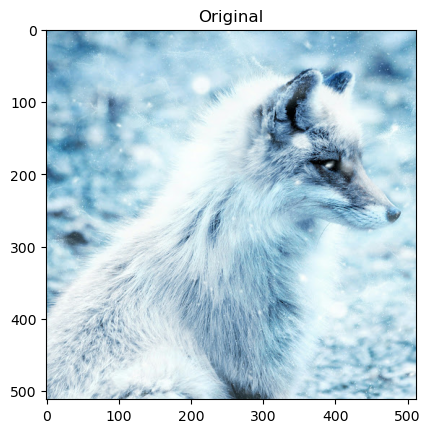

In [15]:
original = Image.open(img_path)
plt.title('Original')
plt.imshow(original)

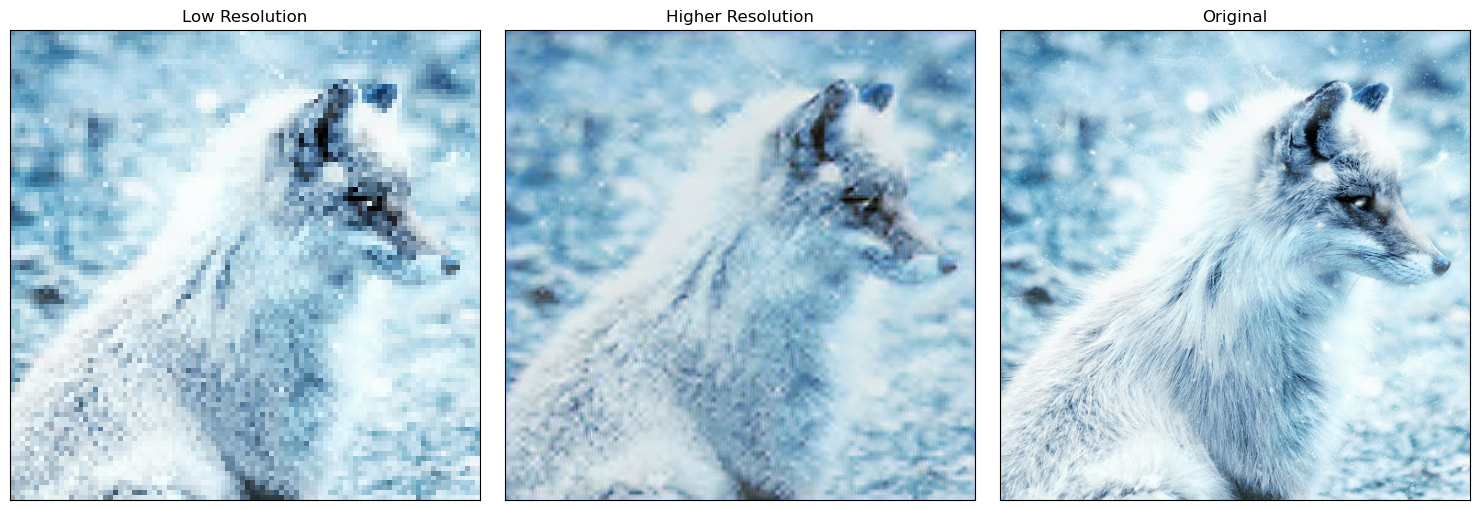

In [16]:
# 1. Generate Sample Image Data (Replace with your actual image data)
# Create two sample images: one normal, one "higher resolution" (more pixels)
# image_normal = np.random.rand(100, 100)  # 100x100 pixels
# image_high_res = np.random.rand(200, 200) # 200x200 pixels (2x resolution)

# OR, if you already have the high-resolution image:
# image_high_res = ... # Your high-resolution image data

# 2. Create the Figure and Subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed

# 3. Plot the Images using imshow()
im1 = axes[0].imshow(hr_image)  # Use appropriate colormap
axes[0].set_title("Low Resolution")

im2 = axes[1].imshow(sr_image)
axes[1].set_title("Higher Resolution")

im3 = axes[2].imshow(original)
axes[2].set_title("Original")


# 4. Remove Axes Ticks and Labels (Optional, for cleaner image display)
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

# 5. Adjust Layout
plt.tight_layout()

# 6. Save the Figure (Optional, control DPI)
plt.savefig("image_comparison.png", dpi=300)

# 7. Show the Plot
plt.show()

In [17]:
fake_image = tf.squeeze(sr_image)

In [18]:
def calculate_psnr(sr_image, original):
    """Calculates PSNR between two images.

    Args:
        sr_image: The super-resolved image (TensorFlow tensor).
        original: The original high-resolution image (TensorFlow tensor).

    Returns:
        The PSNR value (TensorFlow tensor).
    """

    # 1. Ensure data type is float32 and range is [0, 1]
    sr_image = tf.image.convert_image_dtype(sr_image, dtype=tf.float32)
    original = tf.image.convert_image_dtype(original, dtype=tf.float32)

    # 2. Resize if necessary (do this AFTER converting to float and [0,1] range)
    target_shape = tf.shape(original)[:-1] # Get height and width of the original image
    sr_image = tf.image.resize(sr_image, target_shape, method='bicubic')
    original = tf.image.resize(original, target_shape, method='bicubic')

    # 3. Calculate PSNR
    psnr = tf.image.psnr(sr_image, original, max_val=1.0) # max_val should be 1.0 for [0, 1] range

    return psnr

# Example usage (assuming sr_image and original are your image tensors):
psnr_value = calculate_psnr(sr_image, original)

# To get the actual numerical value (not a tensor):
psnr_value_np = psnr_value.numpy()
print(f"PSNR: {psnr_value_np}")

PSNR: 21.770206451416016


In [19]:
def calculate_ssim(sr_image, original):
    """Calculates SSIM between two images.

    Args:
        sr_image: The super-resolved image (TensorFlow tensor).
        original: The original high-resolution image (TensorFlow tensor).

    Returns:
        The SSIM value (TensorFlow tensor).
    """

    # 1. Ensure data type is float32 and range is [0, 1]
    sr_image = tf.image.convert_image_dtype(sr_image, dtype=tf.float32)
    original = tf.image.convert_image_dtype(original, dtype=tf.float32)

    # 2. Resize if necessary (do this AFTER converting to float and [0,1] range)
    target_shape = tf.shape(original)[:-1] # Get height and width of the original image
    sr_image = tf.image.resize(sr_image, target_shape, method='bicubic')
    original = tf.image.resize(original, target_shape, method='bicubic')

    # 3. Calculate SSIM
    ssim = tf.image.ssim(sr_image, original, max_val=1.0) # max_val should be 1.0 for [0, 1] range

    return ssim

# Example usage (assuming sr_image and original are your image tensors):
ssim_value = calculate_ssim(sr_image, original)

# To get the actual numerical value (not a tensor):
ssim_value_np = ssim_value.numpy()
print(f"SSIM: {ssim_value_np}")

SSIM: 0.6498551964759827
